In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV

In [2]:
data = pd.read_stata('debitcard199598.dta')

In [3]:
data.head()

,spending1998,debit_card1998,cash_inventory,interest_rate,wealth,income,spending1995,num_of_banks,num_of_inhabitants,family_size,num_of_earners,average_age,geograph_area,householder_age,householder_education
0,1000.0,0 (No),1000.0,4.823153,1.575000e+06,64867.558594,3000.0,9.0,">20,000 & <=40,000",7,4.0,>30 & <=40,South and Islands,>50 & <=65,elementary school
1,1100.0,1 (Yes),500.0,4.925455,4.127469e+05,61375.425781,1200.0,2.0,">40,000 & <=500,000",2,2.0,>40 & <=50,North,>50 & <=65,elementary school
2,2000.0,1 (Yes),500.0,5.374096,1.030000e+05,40428.539062,2000.0,11.0,">20,000 & <=40,000",4,3.0,<=30,North,>40 & <=50,bachelors degree
3,1500.0,0 (No),900.0,4.925455,2.001000e+05,40283.109375,900.0,17.0,">20,000 & <=40,000",1,1.0,>65,North,>65,elementary school
4,1000.0,0 (No),500.0,5.438059,5.802000e+05,33112.640625,1000.0,4.0,"<=20,000",2,2.0,>65,North,>50 & <=65,elementary school


In [4]:
missing_data = data.isnull().sum()
data['debit_card1998'] = data['debit_card1998'].map({'0 (No)': 0, '1 (Yes)': 1})
inhabitant_categories = ['<=20,000', '>20,000 & <=40,000', '>40,000 & <=500,000', '>500,000']
data['num_of_inhabitants'] = pd.Categorical(data['num_of_inhabitants'], categories=inhabitant_categories, ordered=True)
categorical_columns = ['num_of_inhabitants', 'average_age', 'geograph_area', 'householder_age', 'householder_education']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)


In [5]:
data['debit_card1998']

0      0
1      1
2      1
3      0
4      0
      ..
559    1
560    0
561    1
562    1
563    0
Name: debit_card1998, Length: 564, dtype: category
Categories (2, int64): [0 < 1]

In [6]:
X = data.drop(['spending1998', 'debit_card1998'], axis=1)  # drop the outcome variable and the treatment indicator
y = data['debit_card1998'].astype('int')  # treatment indicator

# Fit the logistic regression model
logit_model = LogisticRegression(solver='liblinear')
logit_model.fit(X, y)

# Get the coefficient for the lagged outcome
lagged_coef = logit_model.coef_[0][data.columns.get_loc('spending1995') - 2]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X_train, y_train)

# Predict the probability of treatment on the test set
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc

0.42568493150684933

In [10]:
log_reg_propensity = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg_propensity.fit(X, y)

# Predict the propensity scores for the entire dataset
data['propensity_score'] = log_reg_propensity.predict_proba(X)[:, 1]

# Show the distribution of propensity scores for both treated and control groups
propensity_scores = data[['debit_card1998', 'propensity_score']]
propensity_scores.head()


,debit_card1998,propensity_score
0,0,0.173228
1,1,0.302570
2,1,0.394212
3,0,0.371824
4,0,0.338218


/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

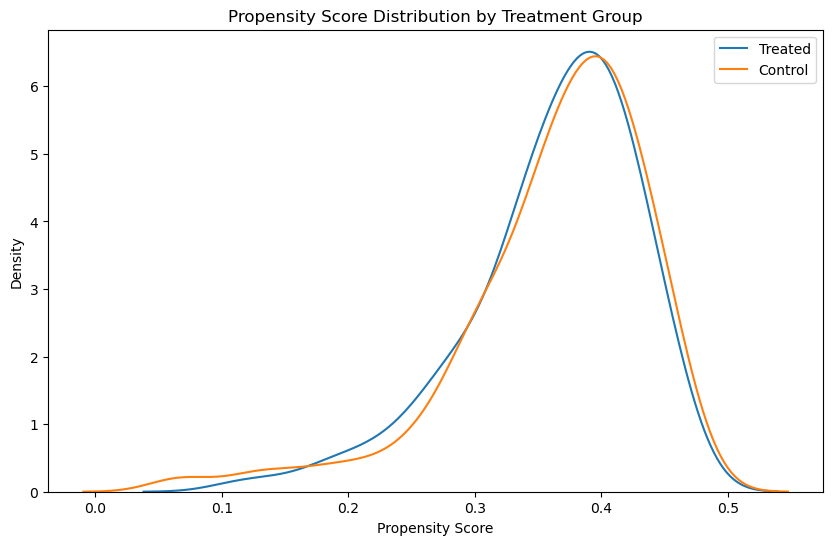

In [12]:


# Plot the distribution of propensity scores for both treated and control groups
plt.figure(figsize=(10, 6))
sns.kdeplot(data[propensity_scores['debit_card1998'] == 1]['propensity_score'], label='Treated')
sns.kdeplot(data[propensity_scores['debit_card1998'] == 0]['propensity_score'], label='Control')
plt.title('Propensity Score Distribution by Treatment Group')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [15]:
X_reg = sm.add_constant(X)  # add a constant term for the intercept
y_reg = data['spending1998']  # outcome variable
X_reg_with_treatment = sm.add_constant(data[['debit_card1998', 'propensity_score']])

# Fit the OLS model including the treatment indicator
ols_model_with_treatment = OLS(y_reg, X_reg_with_treatment)
ols_results_with_treatment = ols_model_with_treatment.fit()

# Extract the coefficient for the treatment indicator and its standard error for the ATT estimation
att_direct_regression = ols_results_with_treatment.params['debit_card1998']
att_direct_regression_se = ols_results_with_treatment.bse['debit_card1998']

att_direct_regression, att_direct_regression_se

(380.6638567938241, 67.00930431226365)

In [21]:
treated = data[data['debit_card1998'] == 1]
control = data[data['debit_card1998'] == 0]

# Use NearestNeighbors to find the closest match in the control group for each treated unit
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Calculate the ATT by averaging the differences in outcomes between matched treated and control units
att_matching = np.mean(treated['spending1998'].values - control.iloc[indices.flatten()]['spending1998'].values)

# Standard error estimation for matching can be complex. It often involves bootstrapping due to the matching procedure.
# We will calculate a simple standard error by computing the standard deviation of the differences divided by the square root of the number of treated units.
se_matching = np.std(treated['spending1998'].values - control.iloc[indices.flatten()]['spending1998'].values) / np.sqrt(len(treated))

att_matching, se_matching

(427.93295, 81.6984329586899)

In [22]:
# Calculate the weights for treated and control units
treated['weight'] = 1
control['weight'] = control['propensity_score'] / (1 - control['propensity_score'])

# Normalize the weights
sum_weights_treated = treated['weight'].sum()
control['weight'] *= sum_weights_treated / control['weight'].sum()

# Combine treated and control units with weights
weighted_data = pd.concat([treated, control])

# Fit a weighted OLS model
weighted_ols = OLS(weighted_data['spending1998'], sm.add_constant(weighted_data['debit_card1998']), weights=weighted_data['weight'])
weighted_ols_results = weighted_ols.fit()

# Extract the coefficient for the treatment indicator and its standard error for the ATT estimation
att_weighting = weighted_ols_results.params['debit_card1998']
att_weighting_se = weighted_ols_results.bse['debit_card1998']

att_weighting, att_weighting_se


/tmp/ipykernel_1082316/783837864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated['weight'] = 1
/tmp/ipykernel_1082316/783837864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control['weight'] = control['propensity_score'] / (1 - control['propensity_score'])
/tmp/ipykernel_1082316/783837864.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

(385.6796053108902, 72.52905493265743)

In [23]:
# Fit a weighted least squares (WLS) model using the correct weights
wls_model = sm.WLS(weighted_data['spending1998'], sm.add_constant(weighted_data['debit_card1998']), weights=weighted_data['weight'])
wls_results = wls_model.fit()

# Extract the coefficient for the treatment indicator and its standard error for the ATT estimation
att_weighting = wls_results.params['debit_card1998']
att_weighting_se = wls_results.bse['debit_card1998']

att_weighting, att_weighting_se


(471.2435800298256, 67.58270950276892)

In [24]:
# Prepare the data for the double-robust estimation by adding the propensity score as a covariate
X_double_robust = sm.add_constant(data[['debit_card1998', 'propensity_score']])

# Fit a weighted least squares (WLS) model for the double-robust estimation
wls_double_robust = sm.WLS(data['spending1998'], X_double_robust, weights=weighted_data['weight'])
wls_double_robust_results = wls_double_robust.fit()

# Extract the coefficient for the treatment indicator and its standard error for the ATT estimation
att_double_robust = wls_double_robust_results.params['debit_card1998']
att_double_robust_se = wls_double_robust_results.bse['debit_card1998']

att_double_robust, att_double_robust_se


(421.4981795062481, 66.8149830741543)

In [105]:
import pyreadr

# Load the data again
rdata_path = 'mepsPS4.rdata'
result = pyreadr.read_r(rdata_path)
meps_data = result['meps.dat']

In [106]:

meps_data.head()

,race,pcs,mcs,sinceCheckUp,smoke,socialLim,cogLim,exercise,male,age,...,mi,stroke,emphysema,cholesterol,cancer,diabetes,arthritis,asthma,anylim,healthExp
0,White,63.98,31.12,5,0.0,0.0,0.0,1.0,0.0,34.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2607
1,Asian,39.49,52.01,1,0.0,0.0,0.0,1.0,1.0,70.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3306
2,Asian,21.51,32.80,1,0.0,1.0,1.0,0.0,0.0,70.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,19811
3,Hispanic,58.02,49.91,3,0.0,0.0,0.0,0.0,1.0,42.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,Hispanic,55.06,50.52,3,0.0,0.0,0.0,0.0,0.0,37.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,403


In [107]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'race' variable
label_encoder = LabelEncoder()
meps_data['race_encoded'] = label_encoder.fit_transform(meps_data['race'])

# Display the mapping of encoded values
race_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
race_mapping


{'Asian': 0, 'Black': 1, 'Hispanic': 2, 'White': 3}

In [108]:
X = meps_data.drop(['race', 'race_encoded', 'healthExp'], axis=1)  # Exclude the outcome and race variables
y = meps_data['race_encoded']  # The dependent variable is the encoded race

# Since we are going to fit a multinomial logistic regression, it's a good practice to scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the multinomial logistic regression model
# We use l1 penalty for feature selection since there are many confounders
logistic_model = LogisticRegression(multi_class='multinomial', solver='saga', penalty='l1', max_iter=5000, random_state=42)
logistic_model.fit(X_scaled, y)

# The model is fit; we can now look at the overlap and balance
logistic_model.coef_

array([[-5.60791377e-02, -1.21630651e-02, -9.60398328e-03,
        -2.23772168e-01, -4.25488202e-02, -1.42558327e-02,
        -2.69760489e-02,  8.83618576e-02,  7.43905045e-02,
        -1.04289278e+00,  2.01194986e-01,  8.37205070e-02,
        -7.31665147e-02,  2.70252728e-02, -6.80416690e-02,
         1.12239856e-02, -6.77355601e-02, -8.77330452e-02,
        -1.04599097e-01,  9.97218721e-02, -1.42766055e-01,
         3.25774821e-02, -1.47198794e-01, -2.50820436e-02,
        -1.35807600e-01],
       [-1.97826863e-02,  8.46361774e-02, -1.54077072e-01,
         1.60125981e-01,  3.03325945e-02,  2.32942539e-02,
         2.69044710e-03, -7.21726367e-02, -7.62679583e-02,
         1.72697512e-01, -4.31883175e-01, -3.43593381e-02,
        -3.07064222e-03,  2.11012121e-01, -6.47431539e-03,
        -5.81965235e-02,  3.45772247e-02,  7.27115601e-02,
         3.33354496e-03, -1.39790780e-01,  1.01208650e-04,
        -1.72335873e-03,  1.02571717e-01,  2.41727487e-02,
         2.71390572e-02],
    

In [109]:
propensity_scores = logistic_model.predict_proba(X_scaled)

# Convert the propensity scores to a DataFrame for easier manipulation
propensity_scores_df = pd.DataFrame(propensity_scores, columns=race_mapping.keys())
propensity_scores_df

,Asian,Black,Hispanic,White
0,0.170916,0.037587,0.337597,0.453899
1,0.312261,0.095101,0.182574,0.410064
2,0.019919,0.276531,0.180670,0.522879
3,0.061326,0.058059,0.494221,0.386395
4,0.117024,0.092464,0.474459,0.316053
...,...,...,...,...
20441,0.003190,0.215015,0.115557,0.666238
20442,0.067557,0.091395,0.359050,0.481998
20443,0.021319,0.080627,0.156049,0.742004
20444,0.077623,0.090723,0.181694,0.649960


/tmp/ipykernel_1082316/2250530180.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(propensity_scores_df[race], label=race, color=color_map[race], shade=True)
/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1082316/2250530180.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This wi

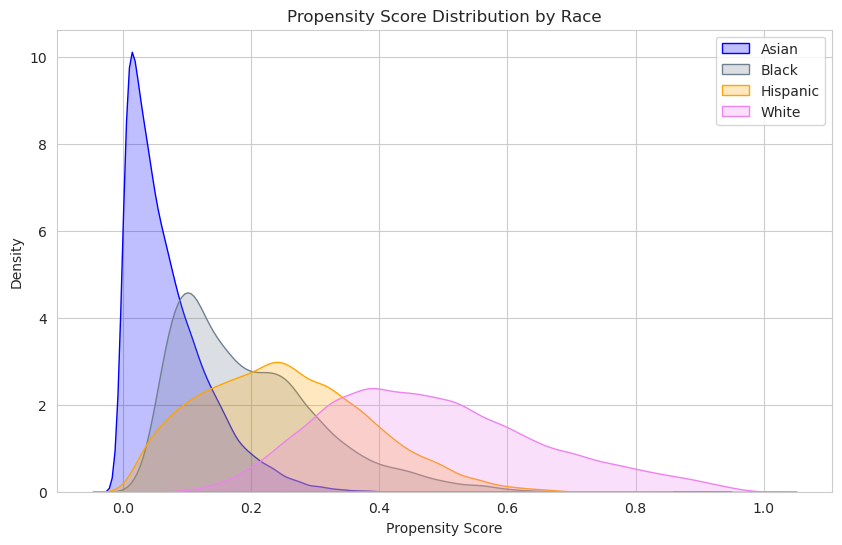

In [111]:
# Set the figure style for Seaborn plots
sns.set_style("whitegrid")

# Define a color map for the races
color_map = {
    'Asian': 'blue',
    'Black': 'slategrey',
    'Hispanic': 'orange',
    'White': 'violet'
}

# Create the plot with specified colors
plt.figure(figsize=(10, 6))
for race in race_mapping.keys():
    sns.kdeplot(propensity_scores_df[race], label=race, color=color_map[race], shade=True)
plt.title('Propensity Score Distribution by Race')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
## save figure to pdf
plt.savefig('propensity_score_distribution.pdf')
plt.show()



In [90]:
# Prepare the data frame with race and covariates for SMD calculation

label_encoder = LabelEncoder()
meps_data['race_encoded'] = label_encoder.fit_transform(meps_data['race'])
meps_data['health'] = meps_data['health'].astype(int)
meps_data['mhealth'] = meps_data['mhealth'].astype(int)

# unique_health = meps_data['health'].unique()
# unique_mhealth = meps_data['mhealth'].unique()

# # Display the unique values
# print("Unique values for 'health':", unique_health)
# print("Unique values for 'mhealth':", unique_mhealth)


In [91]:

# Define the standardized_mean_differences function
def standardized_mean_differences(df, treatment_col, covariate_cols, treatment_groups):
    """
    Calculate the standardized mean differences (SMD) for all covariates across treatment groups.

    :param df: DataFrame containing the treatment and covariates
    :param treatment_col: The name of the column containing the treatment groups
    :param covariate_cols: A list of column names for the covariates
    :param treatment_groups: A list of treatment group names
    :return: A DataFrame with the SMD for each covariate and treatment group comparison
    """
    smd_list = []

    for base_group in treatment_groups:
        for comparison_group in treatment_groups:
            if base_group != comparison_group:
                means_base = df[df[treatment_col] == base_group][covariate_cols].mean()
                means_comp = df[df[treatment_col] == comparison_group][covariate_cols].mean()
                pooled_std = np.sqrt((df[df[treatment_col] == base_group][covariate_cols].std()**2 + 
                                      df[df[treatment_col] == comparison_group][covariate_cols].std()**2) / 2)
                
                smd = (means_base - means_comp) / pooled_std
                smd_list.append(pd.DataFrame({'Base Group': base_group, 
                                              'Comparison Group': comparison_group, 
                                              'SMD': smd}).reset_index())

    # Combine all the SMDs into a single DataFrame
    smd_df = pd.concat(smd_list, ignore_index=True)
    smd_df.rename(columns={'index': 'Covariate'}, inplace=True)
    return smd_df

# Prepare the covariate columns, excluding 'race', 'race_encoded', and 'healthExp'
covariate_columns = [col for col in meps_data.columns if col not in ['race', 'race_encoded', 'healthExp']]

# Calculate the SMD for each covariate across the racial groups
smd_df = standardized_mean_differences(meps_data, 'race', covariate_columns, label_encoder.classes_)

# Filter out the covariates with SMD greater than 0.10 for any race comparison
smd_df_high = smd_df[smd_df['SMD'].abs() > 0.10]

# For better visualization, pivot the table to have covariates as rows and comparisons as columns
smd_df_high_pivot = smd_df_high.pivot(index='Covariate', columns=['Base Group', 'Comparison Group'], values='SMD')

# Display the pivoted table with high SMD values
smd_df_high_pivot



Base Group           Asian                         Black                      \
Comparison Group     Black  Hispanic     White     Asian  Hispanic     White   
Covariate                                                                      
age                    NaN  0.204863 -0.265538       NaN  0.237944 -0.225949   
angina                 NaN       NaN -0.146573       NaN       NaN       NaN   
anylim           -0.387216       NaN -0.457803  0.387216  0.292366       NaN   
arthritis        -0.377869       NaN -0.440197  0.377869  0.345722       NaN   
asthma           -0.195652       NaN -0.175742  0.195652  0.154519       NaN   
bmi              -0.833177 -0.774284 -0.642679  0.833177  0.167820  0.243884   
cancer           -0.112136       NaN -0.392925  0.112136       NaN -0.291705   
chd              -0.147690       NaN -0.224471  0.147690       NaN       NaN   
cholesterol            NaN       NaN -0.138024       NaN       NaN -0.120523   
cogLim           -0.190487       NaN -0.140125  0.190487  0.137875       NaN   
diabetes         -0.163927       NaN       NaN  0.163927       NaN  0.124023   
emphysema        -0.122165       NaN -0.222921  0.122165       NaN -0.117333   
exercise          0.119724  0.140233       NaN -0.119724       NaN -0.130824   
health           -0.267338 -0.246970       NaN  0.267338       NaN  0.169131   
hibp             -0.369163       NaN -0.186240  0.369163  0.412338  0.180332   
male              0.140421       NaN       NaN -0.140421 -0.138027 -0.140178   
married           0.638750  0.213738  0.110077 -0.638750 -0.410860 -0.519508   
mcs               0.105681  0.137763       NaN -0.105681       NaN       NaN   
mhealth          -0.203034 -0.193787 -0.151227  0.203034       NaN       NaN   
mi               -0.158378       NaN -0.217984  0.158378  0.105693       NaN   
pcs               0.348736       NaN  0.261614 -0.348736 -0.259753       NaN   
sinceCheckUp      0.140939 -0.165046       NaN -0.140939 -0.300571 -0.115951   
smoke            -0.357834 -0.101377 -0.355151  0.357834  0.258015       NaN   
socialLim        -0.220422       NaN -0.209004  0.220422  0.180622       NaN   
stroke           -0.207871       NaN -0.168832  0.207871  0.170027       NaN   

Base Group        Hispanic                         White                      
Comparison Group     Asian     Black     White     Asian     Black  Hispanic  
Covariate                                                                     
age              -0.204863 -0.237944 -0.471403  0.265538  0.225949  0.471403  
angina                 NaN       NaN -0.105103  0.146573       NaN  0.105103  
anylim                 NaN -0.292366 -0.362518  0.457803       NaN  0.362518  
arthritis              NaN -0.345722 -0.407950  0.440197       NaN  0.407950  
asthma                 NaN -0.154519 -0.134429  0.175742       NaN  0.134429  
bmi               0.774284 -0.167820       NaN  0.642679 -0.243884       NaN  
cancer                 NaN       NaN -0.377223  0.392925  0.291705  0.377223  
chd                    NaN       NaN -0.160089  0.224471       NaN  0.160089  
cholesterol            NaN       NaN -0.209187  0.138024  0.120523  0.209187  
cogLim                 NaN -0.137875       NaN  0.140125       NaN       NaN  
diabetes               NaN       NaN       NaN       NaN -0.124023       NaN  
emphysema              NaN       NaN -0.193007  0.222921  0.117333  0.193007  
exercise         -0.140233       NaN -0.151352       NaN  0.130824  0.151352  
health            0.246970       NaN  0.147663       NaN -0.169131 -0.147663  
hibp                   NaN -0.412338 -0.228487  0.186240 -0.180332  0.228487  
male                   NaN  0.138027       NaN       NaN  0.140178       NaN  
married          -0.213738  0.410860 -0.103097 -0.110077  0.519508  0.103097  
mcs              -0.137763       NaN       NaN       NaN       NaN       NaN  
mhealth           0.193787       NaN       NaN  0.151227       NaN       NaN  
mi                   

In [92]:
covariates = meps_data.columns.difference(['race', 'race_encoded', 'healthExp']).tolist()
X = meps_data[covariates]
y = meps_data['race_encoded']

# Multinomial logistic regression model
multinomial_logit = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
multinomial_logit.fit(X, y)

# Get the propensity scores for each class
propensity_scores = multinomial_logit.predict_proba(X)

# Create a dataframe for propensity scores with one column for each race
propensity_score_columns = ['propensity_score_' + class_ for class_ in label_encoder.classes_]
propensity_scores_df = pd.DataFrame(propensity_scores, columns=propensity_score_columns)

# Concatenate the propensity scores to the original dataframe
meps_data_with_pscores = pd.concat([meps_data.reset_index(drop=True), propensity_scores_df.reset_index(drop=True)], axis=1)

# Display the first few rows to confirm that the propensity scores have been added
meps_data_with_pscores[propensity_score_columns].head()

/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,propensity_score_Asian,propensity_score_Black,propensity_score_Hispanic,propensity_score_White
0,0.156429,0.037693,0.341540,0.464338
1,0.237202,0.102946,0.189012,0.470839
2,0.036513,0.244785,0.219174,0.499528
3,0.089780,0.054052,0.468125,0.388043
4,0.133086,0.091680,0.476136,0.299098


In [95]:
# Corrected function to calculate Inverse Probability Weights (IPW)
def calculate_ipw_corrected(df, treatment_col, propensity_score_cols):
    """
    Calculate Inverse Probability Weights for each treatment group.

    :param df: DataFrame containing the treatments and propensity scores
    :param treatment_col: The name of the column containing the treatment groups
    :param propensity_score_cols: The list of columns containing the propensity scores for each group
    :return: DataFrame with an additional column for IPW
    """
    # Get the unique treatment codes
    treatment_codes = df[treatment_col].unique()

    # Initialize the IPW column to zeros
    df['ipw'] = 0.0

    # Calculate the IPWs
    for treatment_code in treatment_codes:
        # The rows where the current treatment is applied
        treatment_rows = df[treatment_col] == treatment_code
        
        # The propensity score column for the current treatment
        ps_col = propensity_score_cols[treatment_code]
        
        # Calculate the IPW for the treatment received
        df.loc[treatment_rows, 'ipw'] = 1 / df.loc[treatment_rows, ps_col]
        
        # Calculate the IPWs for the treatments not received
        for other_ps_col in propensity_score_cols:
            if other_ps_col != ps_col:
                df.loc[treatment_rows, 'ipw'] += 1 / (1 - df.loc[treatment_rows, other_ps_col])

    return df

# Apply the corrected IPW calculation to our data
meps_ipw_corrected = calculate_ipw_corrected(meps_data_with_pscores, 'race_encoded', propensity_score_columns)

# Display the first few rows with the new IPW column
meps_ipw_corrected[['race_encoded', 'ipw']].head()
# Checking the summary statistics of the IPW to ensure they are within an acceptable range



,race_encoded,ipw
0,3,5.896907
1,0,8.453418
2,0,31.990283
3,2,5.926061
4,2,5.781426


In [96]:
ipw_summary = meps_ipw_corrected['ipw'].describe()
ipw_summary

count    20446.000000
mean         8.344804
std         32.715041
min          4.042708
25%          5.451904
50%          6.520396
75%          8.326422
max       4397.171010
Name: ipw, dtype: float64

In [101]:
multinomial_logit = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
multinomial_logit.fit(X, y)

# Get the propensity scores for each class
propensity_scores = multinomial_logit.predict_proba(X)

# Create a dataframe for propensity scores with one column for each race
propensity_score_columns = ['propensity_score_' + class_ for class_ in label_encoder.classes_]
propensity_scores_df_no_l1 = pd.DataFrame(propensity_scores, columns=propensity_score_columns)

# Concatenate the propensity scores to the original dataframe
meps_data_with_pscores = pd.concat([meps_data.reset_index(drop=True), propensity_scores_df_no_l1.reset_index(drop=True)], axis=1)

# Display the first few rows to confirm that the propensity scores have been added
meps_data_with_pscores[propensity_score_columns].head()

/home/yurui/anaconda3/envs/drug_response_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,propensity_score_Asian,propensity_score_Black,propensity_score_Hispanic,propensity_score_White
0,0.156429,0.037693,0.341540,0.464338
1,0.237202,0.102946,0.189012,0.470839
2,0.036513,0.244785,0.219174,0.499528
3,0.089780,0.054052,0.468125,0.388043
4,0.133086,0.091680,0.476136,0.299098


In [102]:
from sklearn.utils import resample

# Function to calculate Inverse Probability Weighting (IPW) estimates
def calculate_ipw_estimates(df, treatment_col, outcome_col, propensity_scores, groups, group_comparisons):
    estimates = []
    for (base_group, comparison_group) in group_comparisons:
        # Get the base and comparison group propensity score columns
        base_propensity = 'propensity_score_' + base_group
        comparison_propensity = 'propensity_score_' + comparison_group
        
        # Calculate the weights for the base group
        weights_base = 1 / df.loc[df[treatment_col] == base_group, base_propensity]
        
        # Calculate the weighted average outcome for the base group
        weighted_avg_outcome_base = np.average(df.loc[df[treatment_col] == base_group, outcome_col],
                                               weights=weights_base)
        
        # Calculate the weights for the comparison group
        weights_comparison = 1 / df.loc[df[treatment_col] == comparison_group, comparison_propensity]
        
        # Calculate the weighted average outcome for the comparison group
        weighted_avg_outcome_comparison = np.average(df.loc[df[treatment_col] == comparison_group, outcome_col],
                                                     weights=weights_comparison)
        
        # Calculate the ATT (Average Treatment effect on the Treated)
        att = weighted_avg_outcome_base - weighted_avg_outcome_comparison
        
        # Bootstrap to estimate standard errors
        bootstrapped_att = []
        for _ in range(100):  # using 100 bootstrap samples for illustration, increase for more precision
            # Resample the data
            df_sample = resample(df, n_samples=len(df), replace=True, stratify=df[treatment_col])
            # Recalculate weights
            weights_base_sample = 1 / df_sample.loc[df_sample[treatment_col] == base_group, base_propensity]
            weights_comparison_sample = 1 / df_sample.loc[df_sample[treatment_col] == comparison_group, comparison_propensity]
            # Recalculate weighted averages
            weighted_avg_outcome_base_sample = np.average(df_sample.loc[df_sample[treatment_col] == base_group, outcome_col],
                                                          weights=weights_base_sample)
            weighted_avg_outcome_comparison_sample = np.average(df_sample.loc[df_sample[treatment_col] == comparison_group, outcome_col],
                                                                weights=weights_comparison_sample)
            # Recalculate ATT
            att_sample = weighted_avg_outcome_base_sample - weighted_avg_outcome_comparison_sample
            bootstrapped_att.append(att_sample)
        
        # Calculate standard error from the bootstrap samples
        se = np.std(bootstrapped_att, ddof=1)
        
        estimates.append({
            'Base Group': base_group,
            'Comparison Group': comparison_group,
            'ATT': att,
            'SE': se
        })
    
    return pd.DataFrame(estimates)

# Define the treatment groups and the group comparisons
groups = ['White', 'Black', 'Asian', 'Hispanic']
group_comparisons = [('White', 'Black'), ('White', 'Asian'), ('White', 'Hispanic')]

# Calculate IPW estimates
ipw_estimates = calculate_ipw_estimates(
    meps_data_with_pscores,
    'race',
    'healthExp',
    propensity_scores_df_no_l1,
    groups,
    group_comparisons
)

ipw_estimates


,Base Group,Comparison Group,ATT,SE
0,White,Black,963.931113,195.486365
1,White,Asian,2062.832948,416.833461
2,White,Hispanic,814.457043,344.416742


In [103]:
# Function to calculate Overlap Weights (OW) estimates
def calculate_ow_estimates(df, treatment_col, outcome_col, propensity_scores, groups, group_comparisons):
    estimates = []
    for (base_group, comparison_group) in group_comparisons:
        # Get the base and comparison group propensity score columns
        base_propensity = 'propensity_score_' + base_group
        comparison_propensity = 'propensity_score_' + comparison_group

        # Calculate the overlap weights for the base group
        ow_base = df[base_propensity] * (1 - df[base_propensity])
        ow_comparison = df[comparison_propensity] * (1 - df[comparison_propensity])

        # Normalize weights so they sum up to the number of observations
        ow_base /= ow_base.sum()
        ow_comparison /= ow_comparison.sum()

        # Calculate the weighted average outcome for both groups
        weighted_avg_outcome_base = np.average(df[outcome_col], weights=ow_base)
        weighted_avg_outcome_comparison = np.average(df[outcome_col], weights=ow_comparison)

        # Calculate the average treatment effect
        ate = weighted_avg_outcome_base - weighted_avg_outcome_comparison

        # Bootstrap to estimate standard errors
        bootstrapped_ate = []
        for _ in range(100):  # using 100 bootstrap samples for illustration, increase for more precision
            # Resample the data
            df_sample = resample(df, n_samples=len(df), replace=True)
            # Recalculate weights
            ow_base_sample = df_sample[base_propensity] * (1 - df_sample[base_propensity])
            ow_comparison_sample = df_sample[comparison_propensity] * (1 - df_sample[comparison_propensity])
            ow_base_sample /= ow_base_sample.sum()
            ow_comparison_sample /= ow_comparison_sample.sum()
            # Recalculate weighted averages
            weighted_avg_outcome_base_sample = np.average(df_sample[outcome_col], weights=ow_base_sample)
            weighted_avg_outcome_comparison_sample = np.average(df_sample[outcome_col], weights=ow_comparison_sample)
            # Recalculate ATE
            ate_sample = weighted_avg_outcome_base_sample - weighted_avg_outcome_comparison_sample
            bootstrapped_ate.append(ate_sample)

        # Calculate standard error from the bootstrap samples
        se = np.std(bootstrapped_ate, ddof=1)

        estimates.append({
            'Base Group': base_group,
            'Comparison Group': comparison_group,
            'ATE': ate,
            'SE': se
        })

    return pd.DataFrame(estimates)

# Calculate OW estimates
ow_estimates = calculate_ow_estimates(
    meps_data_with_pscores,
    'race',
    'healthExp',
    propensity_scores_df_no_l1,
    groups,
    group_comparisons
)

ow_estimates


,Base Group,Comparison Group,ATE,SE
0,White,Black,-428.880937,33.509451
1,White,Asian,1012.650808,55.494490
2,White,Hispanic,584.064657,25.741219
